In [1]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from numpy import asarray
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.arima.model import ARIMA

# Data Import and Cleaning

In [2]:
df = pd.read_excel("/Users/surajkwork/Documents/Thesis/thesis/df.xlsx")

The date variable is not in datetime format so it has to be converted.

In [3]:
df['date']= pd.to_datetime(df['date'])
df.index = df['date']
df.sort_index(inplace=True)

Extracting one cluster from the dataset for analysis.

In [4]:
TS1 = df[(df['Plz'] == "['25', '24']")]

And from this cluster, extracting one category for analysis.

In [5]:
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']

In [6]:
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']

In [7]:
datasets = [TS1_A2, TS1_A1A2, TS1_A2A3]

# Modelling - Train, test split

In [8]:
nobs = 6
df_train, df_test = TS1_A1A2[0:-nobs], TS1_A1A2[-nobs:]

In [9]:
df_train

,week,wPreis,Plz,full,date
date,,,,,
2020-09-14,2020-37,-37.519318,"['25', '24']",A1 & A2 - geschreddert,2020-09-14
2020-09-28,2020-39,-28.690096,"['25', '24']",A1 & A2 - geschreddert,2020-09-28
2020-10-12,2020-41,-29.688079,"['25', '24']",A1 & A2 - geschreddert,2020-10-12
2020-10-19,2020-42,-25.630433,"['25', '24']",A1 & A2 - geschreddert,2020-10-19
2020-10-26,2020-43,-29.073794,"['25', '24']",A1 & A2 - geschreddert,2020-10-26
...,...,...,...,...,...
2023-06-26,2023-26,22.501691,"['25', '24']",A1 & A2 - geschreddert,2023-06-26
2023-07-03,2023-27,18.514178,"['25', '24']",A1 & A2 - geschreddert,2023-07-03
2023-07-10,2023-28,28.985554,"['25', '24']",A1 & A2 - geschreddert,2023-07-10


In [10]:
df_test

,week,wPreis,Plz,full,date
date,,,,,
2023-07-31,2023-31,7.458214,"['25', '24']",A1 & A2 - geschreddert,2023-07-31
2023-08-07,2023-32,7.832750,"['25', '24']",A1 & A2 - geschreddert,2023-08-07
2023-08-14,2023-33,3.525113,"['25', '24']",A1 & A2 - geschreddert,2023-08-14
2023-08-21,2023-34,3.896402,"['25', '24']",A1 & A2 - geschreddert,2023-08-21
2023-08-28,2023-35,6.754483,"['25', '24']",A1 & A2 - geschreddert,2023-08-28
2023-09-04,2023-36,2.053265,"['25', '24']",A1 & A2 - geschreddert,2023-09-04


## Prophet

In [11]:
import prophet

In [12]:
from prophet import Prophet

Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
- Datetime column named: ds
- target : y

In [13]:
#pjme_train_prophet = df_train.reset_index() 
pjme_train_prophet = df_train.rename(columns={'date':'ds',
                     'wPreis':'y'})
pjme_train_prophet = pjme_train_prophet[['ds', 'y']]

In [46]:
pjme_train_prophet.shape

(148, 2)

In [76]:
model = Prophet()


In [77]:
model.fit(pjme_train_prophet)

13:26:48 - cmdstanpy - INFO - Chain [1] start processing
13:26:48 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
#pjme_train_prophet = df_train.reset_index() 
pjme_test_prophet = df_test.rename(columns={'date':'ds',
                     'wPreis':'y'})

pjme_test_prophet = pjme_test_prophet[['ds', 'y']]

In [48]:
pjme_test_prophet.shape

(6, 2)

Prophet does a static prediction by default. 
There does not seem to be an option to do a rolling window as the model simply outputs the predictions for the number of steps specified after taking in a set input.

So that leaves only walk-forward validation as the only option to compare.
In this, we can train the prophet model to predict just one step ahead and retrain at every step using the appended new observation. 

In [78]:
future = model.make_future_dataframe(periods=6, freq='W-MON')


In [79]:
future

,ds
0,2020-09-14
1,2020-09-28
2,2020-10-12
3,2020-10-19
4,2020-10-26
...,...
148,2023-08-07
149,2023-08-14
150,2023-08-21
151,2023-08-28


In [56]:
future.shape

(154, 1)

In [57]:
pjme_test_fcst_future = model.predict(future)
pjme_test_fcst_future

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-09-14,-43.407511,-54.852918,-23.144772,-43.407511,-43.407511,4.500807,4.500807,4.500807,4.500807,4.500807,4.500807,0.0,0.0,0.0,-38.906704
1,2020-09-28,-41.998320,-53.517017,-20.663914,-41.998320,-41.998320,5.388606,5.388606,5.388606,5.388606,5.388606,5.388606,0.0,0.0,0.0,-36.609714
2,2020-10-12,-40.589129,-50.430226,-18.916438,-40.589129,-40.589129,5.701258,5.701258,5.701258,5.701258,5.701258,5.701258,0.0,0.0,0.0,-34.887871
3,2020-10-19,-39.884534,-50.367936,-18.115432,-39.884534,-39.884534,5.689639,5.689639,5.689639,5.689639,5.689639,5.689639,0.0,0.0,0.0,-34.194895
4,2020-10-26,-39.179938,-48.833887,-16.484003,-39.179938,-39.179938,5.959221,5.959221,5.959221,5.959221,5.959221,5.959221,0.0,0.0,0.0,-33.220717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,2023-08-14,58.217884,41.407912,72.271171,58.212634,58.222520,-1.755968,-1.755968,-1.755968,-1.755968,-1.755968,-1.755968,0.0,0.0,0.0,56.461917
150,2023-08-21,58.803941,43.764267,74.088138,58.793533,58.813145,-0.152457,-0.152457,-0.152457,-0.152457,-0.152457,-0.152457,0.0,0.0,0.0,58.651484
151,2023-08-28,59.389997,44.420752,75.829365,59.374024,59.404949,1.240705,1.240705,1.240705,1.240705,1.240705,1.240705,0.0,0.0,0.0,60.630702
152,2023-09-04,59.976053,45.962517,78.449723,59.954289,59.995946,2.720408,2.720408,2.720408,2.720408,2.720408,2.720408,0.0,0.0,0.0,62.696461


In [58]:
pjme_test_fcst_future.shape

(154, 16)

In [59]:
future_yhat = pjme_test_fcst_future['yhat'].iloc[-6:]
future_yhat

148    53.379034
149    56.461917
150    58.651484
151    60.630702
152    62.696461
153    64.569426
Name: yhat, dtype: float64

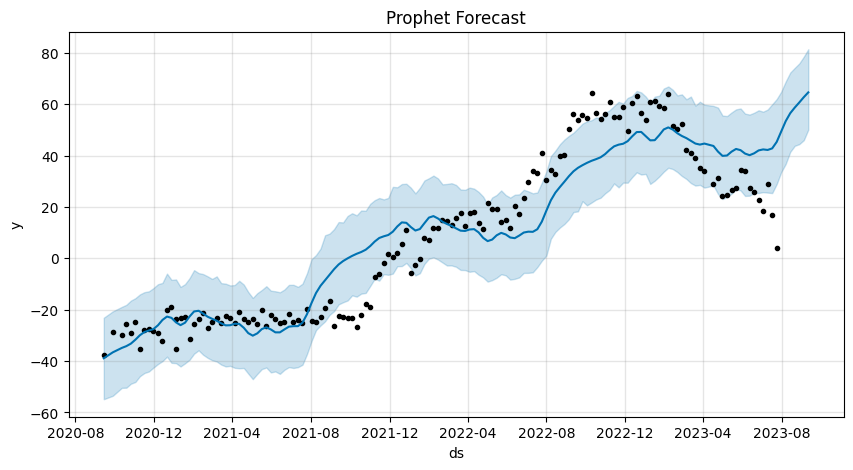

In [60]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst_future, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

In [61]:
def forecast_accuracy(forecast, actual):
      me = np.mean(forecast - actual)             # ME
      rmse = np.mean((forecast - actual)**2)**.5  # RMSE
      # Direction accuracy
      forecast_diff = np.diff(forecast)
      actual_diff = np.diff(actual)
      direction_accuracy = np.mean(np.sign(forecast_diff) == np.sign(actual_diff))
    
      return {'me': me, 'rmse': rmse, 'direction_accuracy': direction_accuracy}


In [62]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Prophet Forecast Accuracy of: wPreis')
accuracy_prod = forecast_accuracy(pjme_test_fcst_future['yhat'].iloc[-6:].values, df_test['wPreis'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Prophet Forecast Accuracy of: wPreis
me     :  54.1448
rmse   :  54.4197
direction_accuracy :  0.6


In [27]:
df_test['wPreis']

date
2023-07-31    7.458214
2023-08-07    7.832750
2023-08-14    3.525113
2023-08-21    3.896402
2023-08-28    6.754483
2023-09-04    2.053265
Name: wPreis, dtype: float64

In [28]:
pjme_test_fcst_future['yhat'].iloc[-6:]

147    49.299807
148    53.379034
149    56.461917
150    58.651484
151    60.630702
152    62.696461
Name: yhat, dtype: float64

In [63]:
future_yhat.index = df_test.index


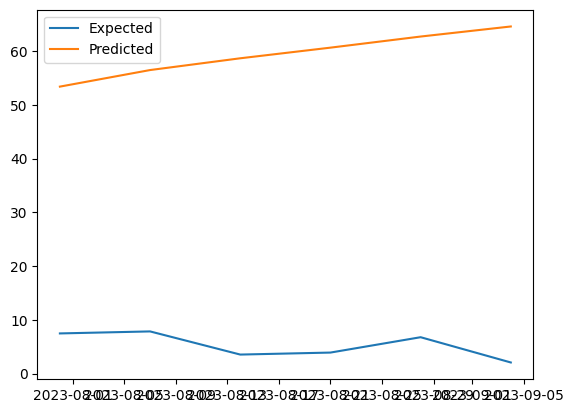

In [64]:
# plot expected vs preducted
plt.plot(df_test['wPreis'], label='Expected')
plt.plot(future_yhat, label='Predicted')
plt.legend()
plt.show()

## Walk-forward validation

In [65]:
len(pjme_test_prophet)

6

In [66]:
pjme_train_prophet

,ds,y
date,,
2020-09-14,2020-09-14,-37.519318
2020-09-28,2020-09-28,-28.690096
2020-10-12,2020-10-12,-29.688079
2020-10-19,2020-10-19,-25.630433
2020-10-26,2020-10-26,-29.073794
...,...,...
2023-06-26,2023-06-26,22.501691
2023-07-03,2023-07-03,18.514178
2023-07-10,2023-07-10,28.985554


In [35]:
pjme_test_prophet

,ds,y
date,,
2023-07-31,2023-07-31,7.458214
2023-08-07,2023-08-07,7.832750
2023-08-14,2023-08-14,3.525113
2023-08-21,2023-08-21,3.896402
2023-08-28,2023-08-28,6.754483
2023-09-04,2023-09-04,2.053265


In [67]:
predictions = {}

In [73]:
input = pjme_train_prophet
for t in range(0,len(pjme_test_prophet)):
    model = Prophet()
    model.fit(input)
    future = model.make_future_dataframe(periods=1, freq='W-MON')
    pred_step = model.predict(future)
    print(pred_step.iloc[-1:]['yhat'])
    predictions = pred_step[-1:]['yhat']
    new_obs = pjme_test_prophet.iloc[t]
    input = input.append(new_obs, ignore_index=True)


13:25:37 - cmdstanpy - INFO - Chain [1] start processing
13:25:37 - cmdstanpy - INFO - Chain [1] done processing
13:25:37 - cmdstanpy - INFO - Chain [1] start processing
13:25:37 - cmdstanpy - INFO - Chain [1] done processing
13:25:37 - cmdstanpy - INFO - Chain [1] start processing
13:25:37 - cmdstanpy - INFO - Chain [1] done processing
13:25:37 - cmdstanpy - INFO - Chain [1] start processing
13:25:37 - cmdstanpy - INFO - Chain [1] done processing
13:25:38 - cmdstanpy - INFO - Chain [1] start processing
13:25:38 - cmdstanpy - INFO - Chain [1] done processing


147    49.299807
Name: yhat, dtype: float64
148    45.757538
Name: yhat, dtype: float64
149    45.584571
Name: yhat, dtype: float64
150    39.603361
Name: yhat, dtype: float64


13:25:38 - cmdstanpy - INFO - Chain [1] start processing
13:25:38 - cmdstanpy - INFO - Chain [1] done processing


151    37.172494
Name: yhat, dtype: float64
152    44.092295
Name: yhat, dtype: float64


In [70]:
pred_step

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-09-14,-46.236301,-55.889758,-25.306599,-46.236301,-46.236301,4.862986,4.862986,4.862986,4.862986,4.862986,4.862986,0.0,0.0,0.0,-41.373315
1,2020-09-28,-44.721030,-55.256859,-23.878932,-44.721030,-44.721030,5.329993,5.329993,5.329993,5.329993,5.329993,5.329993,0.0,0.0,0.0,-39.391038
2,2020-10-12,-43.205759,-51.771308,-22.633751,-43.205759,-43.205759,5.617522,5.617522,5.617522,5.617522,5.617522,5.617522,0.0,0.0,0.0,-37.588237
3,2020-10-19,-42.448124,-51.343310,-21.268325,-42.448124,-42.448124,6.083340,6.083340,6.083340,6.083340,6.083340,6.083340,0.0,0.0,0.0,-36.364784
4,2020-10-26,-41.690489,-49.977459,-20.098147,-41.690489,-41.690489,6.511988,6.511988,6.511988,6.511988,6.511988,6.511988,0.0,0.0,0.0,-35.178501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,2023-08-14,45.359201,12.652219,44.070335,45.359201,45.359201,-17.699570,-17.699570,-17.699570,-17.699570,-17.699570,-17.699570,0.0,0.0,0.0,27.659631
150,2023-08-21,45.600728,14.543225,44.932544,45.600728,45.600728,-15.169869,-15.169869,-15.169869,-15.169869,-15.169869,-15.169869,0.0,0.0,0.0,30.430859
151,2023-08-28,45.842254,20.677175,52.132908,45.842254,45.842254,-9.135853,-9.135853,-9.135853,-9.135853,-9.135853,-9.135853,0.0,0.0,0.0,36.706402
152,2023-09-04,46.083781,27.994291,59.464941,46.083781,46.083781,-1.991486,-1.991486,-1.991486,-1.991486,-1.991486,-1.991486,0.0,0.0,0.0,44.092295
